# Imports and Installations

In [1]:
!pip install lenstronomy
!pip install corner
!pip install image-similarity-measures
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 30.0 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 115 kB 17.0 MB/s 
  Created wheel for lenstronomy: filename=lenstronomy-1.10.4-py3-none-any.whl size=985751 sha256=20e6a773fa56889f4d7c7904e3e4fba1824cf69d186be341797e0c438b58c7fa
  Stored in directory: /root/.cache/pip/wheels/70/ab/0a/bfae36b4746a6c3b0725ba4a75fc6842e039488d5b2a89639d
  Created wheel for schwimmbad: filename=schwimmbad-0.3.2-py3-none-any.whl size=15744 sha256=eefc694386e4f8347c7393488f25682f71e6f9b3252d0665c56acf6acfc73e41
  Stored in directory: /root/.cache/pip/wheels/37/63/1c/16eaacde21747bfd9f8862220535a0ab502c35029536f306c3
Successfully built lenstronomy schwimmbad
Looking in indexes: https:/

In [2]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import copy
from random import *

#import the lens_plot module
from lenstronomy.Plots import lens_plot
from lenstronomy.Plots.model_plot import ModelPlot


# import main simulation class of lenstronomy
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.ImSim.image_model import ImageModel


# lenstronomy utility functions
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.simulation_util as sim_util
# import the ShapeletSet class
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
from lenstronomy.LightModel.Profiles.shapelets_polar import ShapeletSetPolar



'''
import cv2
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, psnr

import phasepack.phasecong as pc
'''


'\nimport cv2\nimport image_similarity_measures\nfrom image_similarity_measures.quality_metrics import rmse, psnr\n\nimport phasepack.phasecong as pc\n'

# Lens Models

In [3]:
def lens_model__(theta_E,gamma,e1,e2):
  kwargs_epl = {'theta_E': theta_E, 'gamma': gamma, 'center_x': 0, 'center_y': 0, 'e1': e1, 'e2': e2} 
  return kwargs_epl

# Source Models

In [4]:
def source_model__(source_type,amp,e1,e2,center_x,center_y):

  if source_type == 'SERSIC_ELLIPSE':
    kwargs_sersic = {'amp': amp, 'R_sersic': 0.1, 'n_sersic': 1.5, 'e1':e1,'e2':e2,'center_x': center_x, 'center_y': center_y}
    return kwargs_sersic 

  if source_type == 'HERNQUIST':
    kwargs_Hernquist={ 'amp': amp,'Rs':0.71,'center_x': center_x, 'center_y': center_y}
    return kwargs_Hernquist
  
  if source_type=='POWER_LAW':
    kwargs_power_law={'amp': amp, 'gamma':0.1, 'e1':e1,'e2':e2, 'center_x': center_x, 'center_y': center_y}
    return kwargs_power_law

  if source_type=='ELLIPSOID':
    kwargs_ellipsoid={'amp': amp, 'radius':0.1, 'e1':e1,'e2':e2, 'center_x': center_x, 'center_y': center_y}
    return kwargs_ellipsoid

  if source_type=='UNIFORM':
    kwargs_UNIFORM={'amp': amp}
    return kwargs_UNIFORM

  if source_type=='GAUSSIAN_ELLIPSE':
    kwargs_gaussian_ellipse={'amp': amp, 'sigma':0.11, 'e1':e1,'e2':e2, 'center_x': center_x, 'center_y': center_y}
    return kwargs_gaussian_ellipse

  if source_type=='CHAMELEON':
    w_c=0.1
    w_t=1
    kwargs_chameleon={'amp':amp, 'w_c':w_c, 'w_t':w_t, 'e1':e1, 'e2':e2, 'center_x':center_x, 'center_y': center_y}
    return kwargs_chameleon
    
  if source_type=='MULTI_GAUSSIAN_ELLIPSE':
    kwargs_gaussian_multi_ellipse={'amp': [amp,0.1*amp,0.5*amp], 'sigma':[0.11,0.3,0.8], 'e1':e1,'e2':e2, 'center_x': center_x, 'center_y': center_y}
    return kwargs_gaussian_multi_ellipse
  
  if source_type=='NIE':
    s_scale=1
    kwargs_NIE={'amp': amp, 'e1':e1,'e2':e2, 's_scale':0.5, 'center_x': center_x, 'center_y': center_y}
    return kwargs_NIE
  
  if source_type=='PJAFFE_ELLIPSE':
    Ra=1
    Rs=5
    kwargs_jaffe={'amp': amp,'Ra':Ra, 'Rs':Rs, 'e1':e1,'e2':e2, 'center_x': center_x, 'center_y': center_y}
    return kwargs_jaffe

  

# Generation Dataset

In [5]:
def new_generating_dataset(n,data_class,psf_class,kwargs_numerics,exp_time,background_rms,x, y):

  lens_light_model_list = []
  kwargs_lens_light_list = []

  lensed_dataset=[]
  unlensed_dataset=[]
  noisy_dataset=[]

  labelset=[]
  lens_parameters_dataset=[]
  
  source_type_list=['NIE','SERSIC_ELLIPSE','HERNQUIST','CHAMELEON','POWER_LAW']#,'GAUSSIAN_ELLIPSE']#MULTI_GAUSSIAN_ELLIPSE'],'UNIFORM','ELLIPSOID']#,'POWER_LAW',,'UNIFORM','GAUSSIAN_ELLIPSE',,'ELLIPSOID',
  lens_type_list=['EPL']#['EPL','SHEAR','POINT_MASS','SIS','NIE','SIE','SERSIC']#',CORED_DENSITY',,'CURVED_ARC_SIS_MST']
  nb_source=len(source_type_list)

  
  for i in tqdm(range(n)):
    source_model_list=[]
    kwargs_source=[]
    
    ## Choice of number of sources
    choix_nb_source=np.random.randint(5,11)
    L_choix_source=np.random.randint(0,nb_source,choix_nb_source)

    ## Parameters of each sources
    for k in L_choix_source:
      source_type=source_type_list[k]
      amp_s=uniform(200,600)
      e1_s=uniform(-0.2,0.2)
      e2_s=uniform(-0.2,0.2)
      center_x=uniform(-2.5,2.5)
      center_y=uniform(-2.5,2.5)

      source_model_list.append(source_type)
      kwargs_source_type=source_model__(source_type,amp_s,e1_s,e2_s,center_x,center_y)
      kwargs_source.append(kwargs_source_type)

    source_model_class = LightModel(source_model_list)
    kwargs_label_source=[source_model_list,kwargs_source]    
    
    ## Lens_parameters
    gamma=uniform(-1,1)
    e1=uniform(-0.2,0.2)
    e2=uniform(-0.2,0.2)
    theta_E=uniform(0.1,0.9)
       
    lens_type='EPL'   
    lens_model_list = [lens_type]
    lens_model_class = LensModel(lens_model_list)

    kwargs_lens_type=lens_model__(theta_E,gamma,e1,e2)
    kwargs_lens=[kwargs_lens_type]

    kwargs_label_lens=[lens_model_list,kwargs_lens]
    
    ### Generation DATA
    imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, source_model_class=source_model_class, kwargs_numerics=kwargs_numerics)#, lens_light_model_class=None,point_source_class=None)
    # image without noise
    image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None, source_add=True,lens_light_add=False,  point_source_add=False)
    # noisy image
    poisson = image_util.add_poisson(image_model, exp_time=exp_time)
    bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
    image_real = image_model + poisson + bkg
    # unlensed image
    imageModel_u = ImageModel(data_class, psf_class, kwargs_numerics=kwargs_numerics,source_model_class=source_model_class)#,lens_model_class=None)#, lens_light_model_class=None,point_source_class=None)
    unlensed_image = imageModel_u.image(kwargs_lens=None, kwargs_source=kwargs_source, kwargs_lens_light=None, kwargs_ps=None, source_add=True, lens_light_add=False,point_source_add=False)

    #local_data=[unlensed_image,image_model,image_real]

    kwargs_label=[kwargs_label_source,kwargs_label_lens]
    local_label=kwargs_label
    
    unlensed_dataset.append(np.array(unlensed_image))
    lensed_dataset.append(np.array(image_model))
    noisy_dataset.append(np.array(image_real))

    labelset.append(np.array(local_label))
    lens_parameters_dataset.append(np.array([theta_E,gamma,0,0,e1,e2]))

  unlensed_dataset=np.array(unlensed_dataset)
  lensed_dataset=np.array(lensed_dataset)  
  noisy_dataset=np.array(noisy_dataset)  
  labelset=np.array(labelset)
  lens_parameters_dataset=np.array(lens_parameters_dataset)
  return unlensed_dataset,lensed_dataset,noisy_dataset,labelset,lens_parameters_dataset

In [6]:
## For the Lens Model Plot

def coord_source_pos(labelset,n):
  L_sourcePos_x=[]
  L_sourcePos_y=[]

  for ind in range(n):
    label_source=labelset[ind][0][1]
    sourcePos_x=[]
    sourcePos_y=[]
    for i in range(len(label_source)):
      center_x=label_source[i]["center_x"]
      center_y=label_source[i]["center_y"]
      sourcePos_x.append(center_x)
      sourcePos_y.append(center_y)
    L_sourcePos_x.append(sourcePos_x)
    L_sourcePos_y.append(sourcePos_y)

  return L_sourcePos_x,L_sourcePos_y

# Shapelet Reconstruction

In [7]:
def shapelet_reconstruction(n,choice_type_shapelet,unlensed_dataset,lensed_dataset,noisy_dataset,beta,nmax,x,y,deltaPix):
  
  unlensed_dataset_reconstructed=[]
  unlensed_coeff_dataset=[]

  lensed_dataset_reconstructed=[]
  lensed_coeff_dataset=[]

  noisy_dataset_reconstructed=[]
  noisy_coeff_dataset=[]

  #Polar or Cartesian
  shapeletSet = choice_type_shapelet
  for ind in tqdm(range(n)):
    
    image_1d = util.image2array(unlensed_dataset[ind])
    coeff_ngc = shapeletSet.decomposition(image_1d, x, y, nmax, beta, deltaPix=deltaPix, center_x=0, center_y=0) 
    # reconstruct NGC1300 with the shapelet coefficients
    image_reconstructed = shapeletSet.function(x, y, coeff_ngc, nmax, beta, center_x=0, center_y=0)
    # turn 1d array back into 2d image
    image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image
    unlensed_dataset_reconstructed.append(np.array(image_reconstructed_2d))
    unlensed_coeff_dataset.append(np.array(coeff_ngc))

  
    image_1d = util.image2array(lensed_dataset[ind])  
    # decompose image and return the shapelet coefficients
    coeff_ngc = shapeletSet.decomposition(image_1d, x, y, nmax, beta, deltaPix=deltaPix, center_x=0, center_y=0) 
    # reconstruct NGC1300 with the shapelet coefficients
    image_reconstructed = shapeletSet.function(x, y, coeff_ngc, nmax, beta, center_x=0, center_y=0)
    # turn 1d array back into 2d image
    image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image
    lensed_dataset_reconstructed.append(np.array(image_reconstructed_2d))
    lensed_coeff_dataset.append(np.array(coeff_ngc))


    image_1d = util.image2array(noisy_dataset[ind])  
    # decompose image and return the shapelet coefficients
    coeff_ngc = shapeletSet.decomposition(image_1d, x, y, nmax, beta, deltaPix=deltaPix, center_x=0, center_y=0) 
    # reconstruct NGC1300 with the shapelet coefficients
    image_reconstructed = shapeletSet.function(x, y, coeff_ngc, nmax, beta, center_x=0, center_y=0)
    # turn 1d array back into 2d image
    image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image
    noisy_dataset_reconstructed.append(np.array(image_reconstructed_2d))
    noisy_coeff_dataset.append(np.array(coeff_ngc))

  unlensed_dataset_reconstructed=np.array(unlensed_dataset_reconstructed)
  unlensed_coeff_dataset=np.array(unlensed_coeff_dataset)

  lensed_dataset_reconstructed=np.array(lensed_dataset_reconstructed)
  lensed_coeff_dataset=np.array(lensed_coeff_dataset)

  noisy_dataset_reconstructed=np.array(noisy_dataset_reconstructed)
  noisy_coeff_dataset=np.array(noisy_coeff_dataset)

  return(unlensed_dataset_reconstructed,lensed_dataset_reconstructed,noisy_dataset_reconstructed,unlensed_coeff_dataset,lensed_coeff_dataset,noisy_coeff_dataset)

# Vizualization Basis Shapelets

len(shapelet_basis) = 45


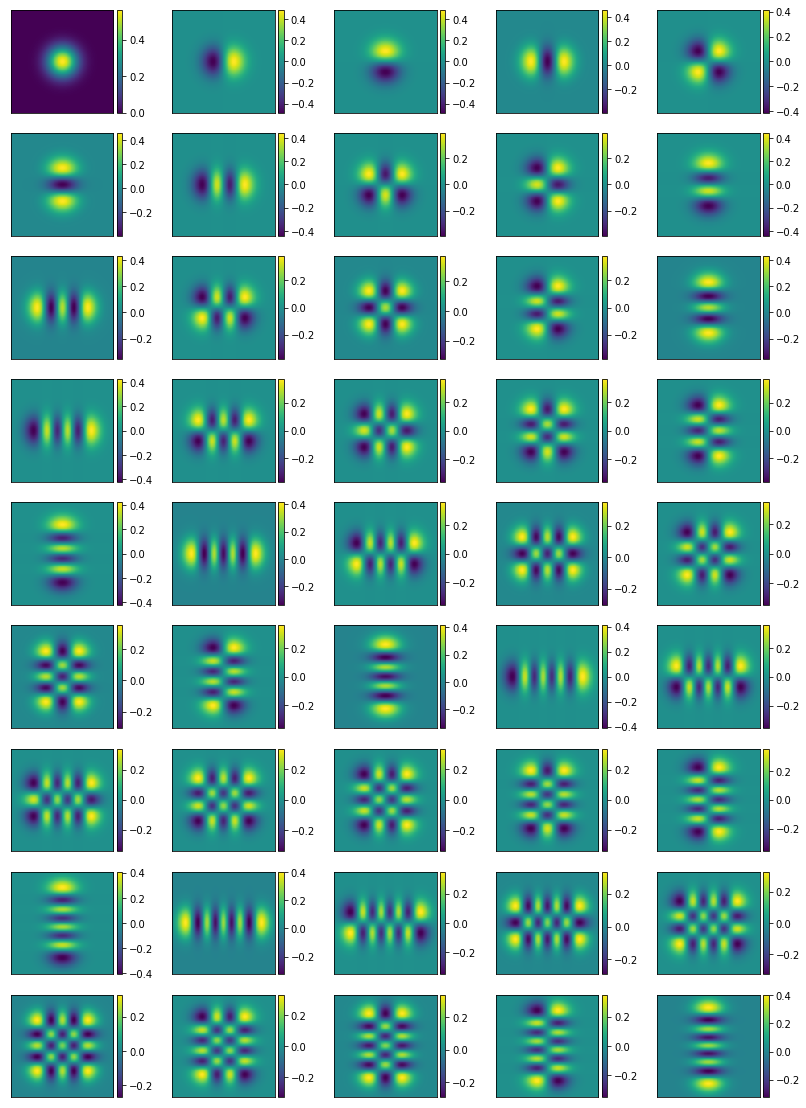

In [ ]:
n_max=8
beta=9.8
numPix=128
deltaPix=0.75
shapeletSet=ShapeletSet()
shapelet_basis=shapeletSet.shapelet_basis_2d(n_max, beta, numPix, deltaPix=deltaPix, center_x=0, center_y=0)
print('len(shapelet_basis) = '+str(len(shapelet_basis)))

n_shap=len(shapelet_basis)

def nb_ligne_col(n_shap):
  if n_shap%5==0:
    nb_ligne=n_shap//5
    nb_colonne=5
    return nb_ligne,nb_colonne
  elif n_shap%4==0:
    nb_ligne=n_shap//4
    nb_colonne=4
    return nb_ligne,nb_colonne
  elif n_shap%3==0:
    nb_ligne=n_shap//3
    nb_colonne=3
    return nb_ligne,nb_colonne
  else :
    return n_shap,0

nb_ligne, nb_colonne=nb_ligne_col(n_shap)

f, axes = plt.subplots(nb_ligne, nb_colonne, figsize=(14,20), sharex=False, sharey=False)
for i in range(nb_ligne):
  for j in range(nb_colonne):
    ax = axes[i][j]
    im = ax.matshow(shapelet_basis[j+i*nb_colonne], origin='lower')
    #ax.set_title(position(j+i*nb_colonne))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')

# A compiler generation dataset

In [73]:
# data specifics
background_rms = .005  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 128  #  cutout pixel size
deltaPix =0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.05  # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)

# generate the coordinate grid and image properties
#kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
#data_class = ImageData(**kwargs_data)
kernel_point_source=np.eye(3)
# generate the psf variables
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}#, 'kernel_point_source':kernel_point_source}
psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}


x, y = util.make_grid(numPix, deltaPix)
n=50


unlensed_dataset,lensed_dataset,noisy_dataset,labelset,lensed_parameters_dataset=new_generating_dataset(n,data_class,psf_class,kwargs_numerics,exp_time,background_rms,x,y)

100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


0.587165737660935
343.3833864025057


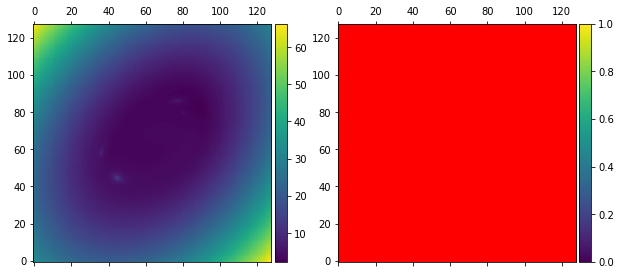

In [82]:
import matplotlib.colors as mc
import matplotlib.image

print(np.min(data))
print(np.max(data))
ind=46
data=lensed_dataset[ind]
data_=np.zeros((128,128,3))
data_[:,:,0]=data
f, axes = plt.subplots(1, 2, figsize=(10,10), sharex=False, sharey=False)
ax=axes[0]
im = ax.matshow(data, origin='lower',vmin=np.min(data),vmax=np.max(data))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax=axes[1]
im = ax.matshow(data_, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

plt.show()

#matplotlib.image.imsave("content/dataset/"+".png",data,vmin=0,vmax=255)
        
#print(data_)

In [ ]:
print('Unlensed Dataset shape is : '+str(unlensed_dataset.shape))

Unlensed Dataset shape is : (10000, 128, 128)


In [ ]:
print(' Labelset shape is : '+str(labelset.shape))

 Labelset shape is : (10000, 2, 2)


In [ ]:
lensed_parameters_dataset_=np.transpose(labelset)[1][1]
lensed_parameters_dataset_=lensed_parameters_dataset_.reshape(10000,-1)

In [ ]:
print(lensed_parameters_dataset.shape)

(10000, 6)


# Check Lensing Equation

### Check Lensing equation ARCSEC

In [ ]:
from lenstronomy.LensModel.Profiles import epl
from lenstronomy.LensModel.single_plane import SinglePlane
from lenstronomy.LensModel.MultiPlane.multi_plane import MultiPlane

deltaPix=0.05 ##in arcsec
numPix=128
x, y = util.make_grid(numPix, deltaPix)

## Choice of data
ind=1
unlensed_image=unlensed_dataset[ind][0]
lensed_image=lensed_dataset[ind][1]

# Parameters
EPL_=epl.EPL()
kwargs_lens=labelset[ind][1][1]


## Theta
theta_x=copy.deepcopy(x)
theta_y=copy.deepcopy(y)

theta_x=theta_x.reshape(-1,numPix)
theta_y=theta_y.reshape(-1,numPix)


## Lensing Potential
vector_potential=EPL_.function(theta_x, theta_y, kwargs_lens[0]["theta_E"], kwargs_lens[0]["gamma"], kwargs_lens[0]["e1"], kwargs_lens[0]["e2"],0,0)


potential=vector_potential.reshape(-1,numPix)

### Deflection angle
alpha_x,alpha_y=np.gradient(potential,deltaPix)

#alpha_x,alpha_y=EPL_.derivatives(theta_x, theta_y, kwargs_lens[0]["theta_E"], kwargs_lens[0]["gamma"], kwargs_lens[0]["e1"], kwargs_lens[0]["e2"], 0, 0)
#alpha_x,alpha_y=alpha_x.reshape(-1,numPix),alpha_y.reshape(-1,numPix)


##Lensing equation
beta_x,beta_y=theta_x-alpha_x,theta_y-alpha_y

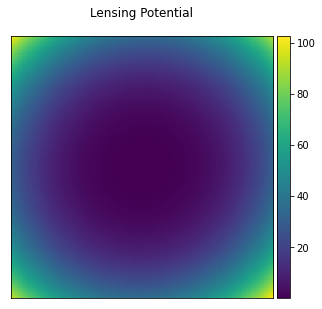

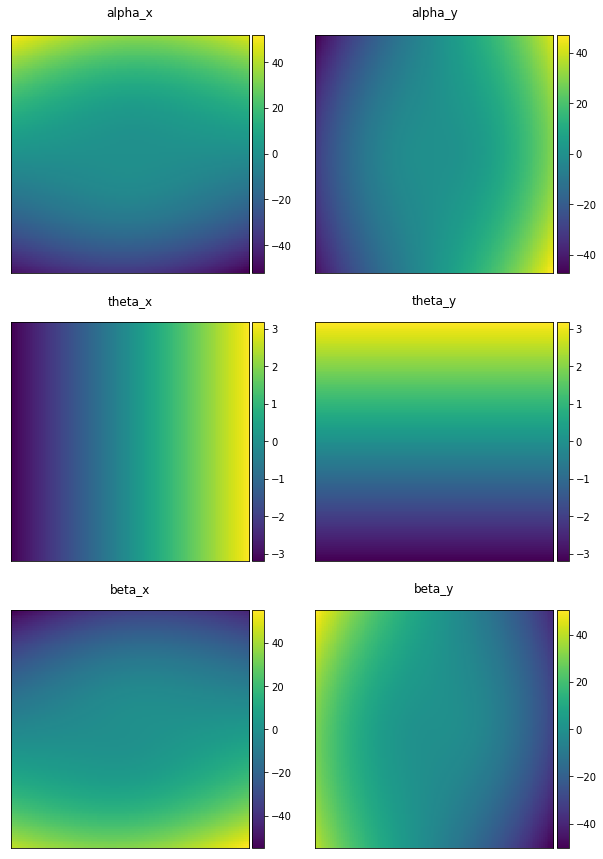

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(5, 10), sharex=False, sharey=False)
im = ax.matshow(potential, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('Lensing Potential')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')
plt.show()



f, axes = plt.subplots(3, 2, figsize=(10, 15), sharex=False, sharey=False)
ax=axes[0][0]
im = ax.matshow(alpha_x, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('alpha_x')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax=axes[0][1]
im = ax.matshow(alpha_y, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('alpha_y')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')


ax=axes[1][0]
im = ax.matshow(theta_x, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('theta_x')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax=axes[1][1]
im = ax.matshow(theta_y, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('theta_y')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')


ax=axes[2][0]
im = ax.matshow(beta_x, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('beta_x')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax=axes[2][1]
im = ax.matshow(beta_y, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('beta_y')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [ ]:
numPix=128
deltaPix=0.05

shift = deltaPix * (numPix - 1) / 2

## Beta in pixel unit
Coord_beta_x=(beta_x+shift)/(deltaPix)
Coord_beta_y=(theta_y+shift)/(deltaPix)
Coord_beta_x=np.array(Coord_beta_x).reshape(-1,numPix)
Coord_beta_y=np.array(Coord_beta_y).reshape(-1,numPix)

## Theta in pixel unit
Coord_theta_x=(theta_x+shift)/(deltaPix)
Coord_theta_y=(theta_y+shift)/(deltaPix)
Coord_theta_x=np.array(Coord_theta_x).reshape(-1,numPix)
Coord_theta_y=np.array(Coord_theta_y).reshape(-1,numPix)


## Comparaison between unlensed_image[beta_x[i][j]][beta_y[i][j]] and lensed_image[theta_x[i][j]][theta_y[i][j]]
Coord_list_x=[]
Coord_list_y=[]
L_=[]
A=np.zeros((numPix,numPix))

for i in range(numPix):
  for j in range(numPix):
    if int(Coord_beta_x[i][j])<128 and int(Coord_beta_x[i][j])>=0:
      if int(Coord_beta_y[i][j])<128 and int(Coord_beta_y[i][j])>=0:
        A[int(Coord_beta_x[i][j])][int(Coord_beta_y[i][j])]=unlensed_image[int(Coord_beta_x[i][j])][int(Coord_beta_y[i][j])]
        Coord_list_x.append(int(Coord_beta_x[i][j]))
        Coord_list_y.append(int(Coord_beta_y[i][j]))
        #print('lensed = '+str(lensed_image[int(Coord_theta_x[i][j])][int(Coord_theta_y[i][j])]))
        #print('unlensed = '+str(unlensed_image[int(Coord_beta_x[i][j])][int(Coord_beta_y[i][j])]))
        L_.append(np.abs(lensed_image[int(Coord_theta_x[i][j])][int(Coord_theta_y[i][j])]-unlensed_image[int(Coord_beta_x[i][j])][int(Coord_beta_y[i][j])]))

plt.plot(L_)
plt.title('The number of pixels where the comparaison is < 0.1 : '+str(np.count_nonzero(np.where(np.abs(np.array(L_))<0.1))))
plt.show()

print(len(L_))

f, axes = plt.subplots(1, 2, figsize=(int(0.8*nb_ligne), 3*nb_ligne), sharex=False, sharey=False)
ax=axes[0]
ax.imshow(np.log10(A))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('UN Lensed Image')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax=axes[1]
ax.imshow(np.log10(unlensed_image))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('UN Lensed Image')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')
plt.plot()


IndexError: ignored

### Check Lensing Equation in Pixel Unit

In [ ]:
from lenstronomy.LensModel.Profiles import epl

numPix=128
deltaPix=0.05 ##in arcsec
# Grid
x, y = util.make_grid(numPix, deltaPix)

#Choice of data
ind=0
unlensed_image=dataset[ind][0]
lensed_image=dataset[ind][1]

# Lens Parameters
EPL_=epl.EPL()
kwargs_lens=labelset[ind][1][1]

# Image size Parameters
shift=deltaPix * (numPix - 1) / 2


x_=copy.deepcopy(x)
y_=copy.deepcopy(y)

##Theta in pixel unit
theta_x=(x_+shift)/(deltaPix)
theta_y=(y_+shift)/(deltaPix)


vector_potential=EPL_.function(theta_x, theta_y, kwargs_lens[0]["theta_E"], kwargs_lens[0]["gamma"], kwargs_lens[0]["e1"], kwargs_lens[0]["e2"],63.5,63.5)
#vector_potential_2=lensing_pot(theta_x, theta_y, kwargs_lens[0]["theta_E"], kwargs_lens[0]["gamma"], kwargs_lens[0]["e1"], kwargs_lens[0]["e2"],63.5,63.5)

print(vector_potential)
## Reshape potential in matrix
potential=vector_potential.reshape(-1,numPix)

# Defelction angle alpha 
#alpha_x,alpha_y=EPL_.derivatives(theta_x, theta_y, kwargs_lens[0]["theta_E"], kwargs_lens[0]["gamma"], kwargs_lens[0]["e1"], kwargs_lens[0]["e2"], 63.5, 63.5)
alpha_x,alpha_y=np.gradient(potential)

theta_x=np.array(theta_x).reshape(-1,numPix)
theta_y=np.array(theta_y).reshape(-1,numPix)
## Lensing equation 
beta_x,beta_y=theta_x-alpha_x,theta_y-alpha_y

[155203.31313594 152394.82805446 149657.53002089 ... 149657.53002089
 152394.82805446 155203.31313594]


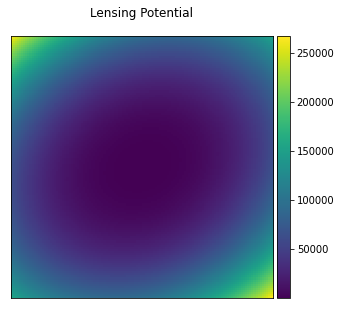

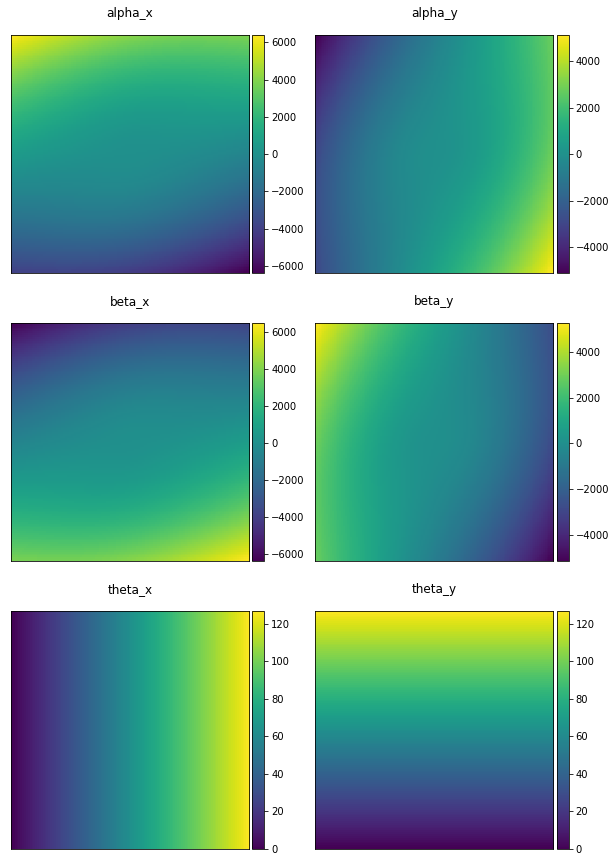

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(5, 10), sharex=False, sharey=False)
im = ax.matshow(potential, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('Lensing Potential')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')
plt.show()


f, axes = plt.subplots(3, 2, figsize=(10, 15), sharex=False, sharey=False)
ax=axes[0][0]
im = ax.matshow(alpha_x, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('alpha_x')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax=axes[0][1]
im = ax.matshow(alpha_y, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('alpha_y')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax=axes[1][0]
im = ax.matshow(beta_x, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('beta_x')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax=axes[1][1]
im = ax.matshow(beta_y, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('beta_y')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax=axes[2][0]
im = ax.matshow(theta_x, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('theta_x')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')

ax=axes[2][1]
im = ax.matshow(theta_y, origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
ax.set_title('theta_y')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')
plt.show()

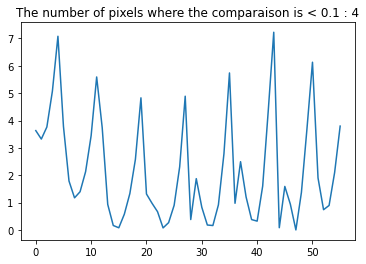

In [ ]:
numPix=128
deltaPix=0.05

shift = deltaPix * (numPix - 1) / 2

## Comparaison between unlensed_image[beta_x[i][j]][beta_y[i][j]] and lensed_image[theta_x[i][j]][theta_y[i][j]]
L_=[]
for i in range(numPix):
  for j in range(numPix):
    if int(beta_x[i][j])<128 and int(beta_x[i][j])>=0:
      if int(beta_y[i][j])<128 and int(beta_y[i][j])>=0:
        
        L_.append(np.abs(lensed_image[i][j]-unlensed_image[int(beta_x[i][j])][int(beta_y[i][j])]))

plt.plot(L_)
plt.title('The number of pixels where the comparaison is < 0.1 : '+str(np.count_nonzero(np.where(np.abs(np.array(L_))<0.1))))
plt.show()

# A compiler shapelet reconstruction

In [ ]:

theta_min=0.75
theta_max=128
n_max=theta_max/theta_min-1
beta=np.sqrt(theta_max*theta_min)
print(beta)
print(n_max)

9.797958971132712
169.66666666666666


In [ ]:
numPix=170
nmax=170

theta_max=numPix
theta_min=theta_max/(nmax+1)
beta=np.sqrt(theta_max*theta_min)

nmax=int(theta_max/theta_min-1)
print(theta_min)


0.9941520467836257


In [ ]:
n=1000
choice_type_shapelet=ShapeletSet()

theta_min=0.75
theta_max=128

beta=np.sqrt(theta_max*theta_min)
nmax=int(theta_max/theta_min-1)

print(beta)
print(nmax)

x,y=util.make_grid(numPix=theta_max,deltapix=theta_min)
delta=1
unlensed_dataset_reconstructed,lensed_dataset_reconstructed,noisy_dataset_reconstructed,unlensed_coeff_dataset,lensed_coeff_dataset,noisy_coeff_dataset=shapelet_reconstruction(n,choice_type_shapelet,unlensed_dataset,lensed_dataset,noisy_dataset,beta,nmax,x,y,delta)

9.797958971132712
169


  3%|▎         | 26/1000 [03:10<1:58:49,  7.32s/it]


KeyboardInterrupt: ignored

In [ ]:
print(dataset_reconstructed.shape)

(30, 3, 128, 128)


# Fonctions to vizualize

In [43]:
def vizualize_dataset(L_affichage,nb_source,unlensed_dataset,lensed_dataset,noisy_dataset,labelset,n,nb_affichage,numPix,deltaPix):
  numPix,deltaPix=numPix,deltaPix
  lens_type='EPL'   
  lens_model_list = [lens_type]
  lensModel=LensModel(lens_model_list)

  L_sourcePos_x,L_sourcePos_y=coord_source_pos(labelset,n)
  # display the initial simulated image
  '''
  cmap_string = 'gray'
  cmap = plt.get_cmap(cmap_string)
  cmap.set_bad(color='k', alpha=1.)
  cmap.set_under('k')
  v_min = -4
  v_max = 1
  '''
  i=0
  nb_ligne=len(L_affichage)
  f, axes = plt.subplots(nb_ligne, 4, figsize=(int(0.8*nb_ligne), 3*nb_ligne), sharex=False, sharey=False)
  for ind in L_affichage:
    
    # sequence of weak lensing
    ax = axes[i][0]
    im = ax.matshow(np.log10(unlensed_dataset[ind]), origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,   extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Unlensed Image')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
      
    ax = axes[i][1]
    im = ax.matshow(np.log10(lensed_dataset[ind]), origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,  extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Lensed Image')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
    

    ax = axes[i][2]
    im = ax.matshow(np.log10(noisy_dataset[ind]), origin='lower')#,vmin=v_min, vmax=v_max, cmap=cmap,  extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Noisy image')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')

    
    sourcePos_x=L_sourcePos_x[ind]
    sourcePos_y=L_sourcePos_y[ind]
    kwargs_lens=labelset[ind][1][1]
    ax=axes[i][3]
    lens_plot.lens_model_plot(ax,lensModel,kwargs_lens,numPix,deltaPix,sourcePos_x,sourcePos_y,with_caustics=True,with_convergence=True)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Lens Model PEMD')

    i=i+1

  plt.show()

In [44]:
def vizualize_dataset_shapelet(L_affichage,dataset_reconstructed,n,nb_affichage,nb_source):
  
  # display the initial simulated image
  '''
  cmap_string = 'gray'
  cmap = plt.get_cmap(cmap_string)
  cmap.set_bad(color='k', alpha=1.)
  cmap.set_under('k')
  v_min = -4
  v_max = 1
  '''
  nb_ligne=len(L_affichage)
  i=0
  f, axes = plt.subplots(nb_ligne, 3, figsize=(int(0.5*nb_ligne), 3*nb_ligne), sharex=False, sharey=False)
  for ind in L_affichage:
    # sequence of weak lensing
    ax = axes[i][0]
    im = ax.matshow(np.log10(dataset_reconstructed[ind][0]), origin='lower')#, vmin=v_min, vmax=v_max, cmap=cmap,  extent=[0, 1, 0, 1]) #vmin=v_min, vmax=v_max, cmap=cmap,
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
    #ax.set_title('Source Image')
    ax.autoscale(False)
    
    ax = axes[i][1]
    im = ax.matshow(np.log10(dataset_reconstructed[ind][1]), origin='lower')#, vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1]) #vmin=v_min, vmax=v_max, cmap=cmap,
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
    #ax.set_title(labelset_ind_s[ind][j-1][0])
    ax.autoscale(False)

    ax = axes[i][2]
    im = ax.matshow(np.log10(dataset_reconstructed[ind][2]), origin='lower')#, vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1]) #vmin=v_min, vmax=v_max, cmap=cmap,
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical')
    #ax.set_title(labelset_ind_s[ind][j][0])
    ax.autoscale(False)
    
    i=i+1

  plt.show()


def vizualize_dataset_coeff_shapelet(len_coeff_shapelet,L_affichage,coeff_dataset,n,nb_affichage,nb_source):
  # display the initial simulated image
  '''
  cmap_string = 'gray'
  cmap = plt.get_cmap(cmap_string)
  cmap.set_bad(color='k', alpha=1.)
  cmap.set_under('k')
  v_min = -4
  v_max = 1
  '''
  x_ax_shapelett=np.linspace(0,len_coeff_shapelet-1,num=len_coeff_shapelet,dtype='int')

  nb_ligne=len(L_affichage)
  i=0
  f, axes = plt.subplots(nb_ligne, 3, figsize=(int(0.5*nb_ligne), 3*nb_ligne), sharex=False, sharey=False)
  for ind in L_affichage:
    # sequence of weak lensing
    ax = axes[i][0]
    ax.plot(x_ax_shapelett,coeff_dataset[ind][0])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    
    ax = axes[i][1]
    ax.plot(x_ax_shapelett,coeff_dataset[ind][1])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

    ax = axes[i][2]
    ax.plot(x_ax_shapelett,coeff_dataset[ind][2])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    
    i=i+1

  plt.show()

# Plots

Plot Dataset

[ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log10


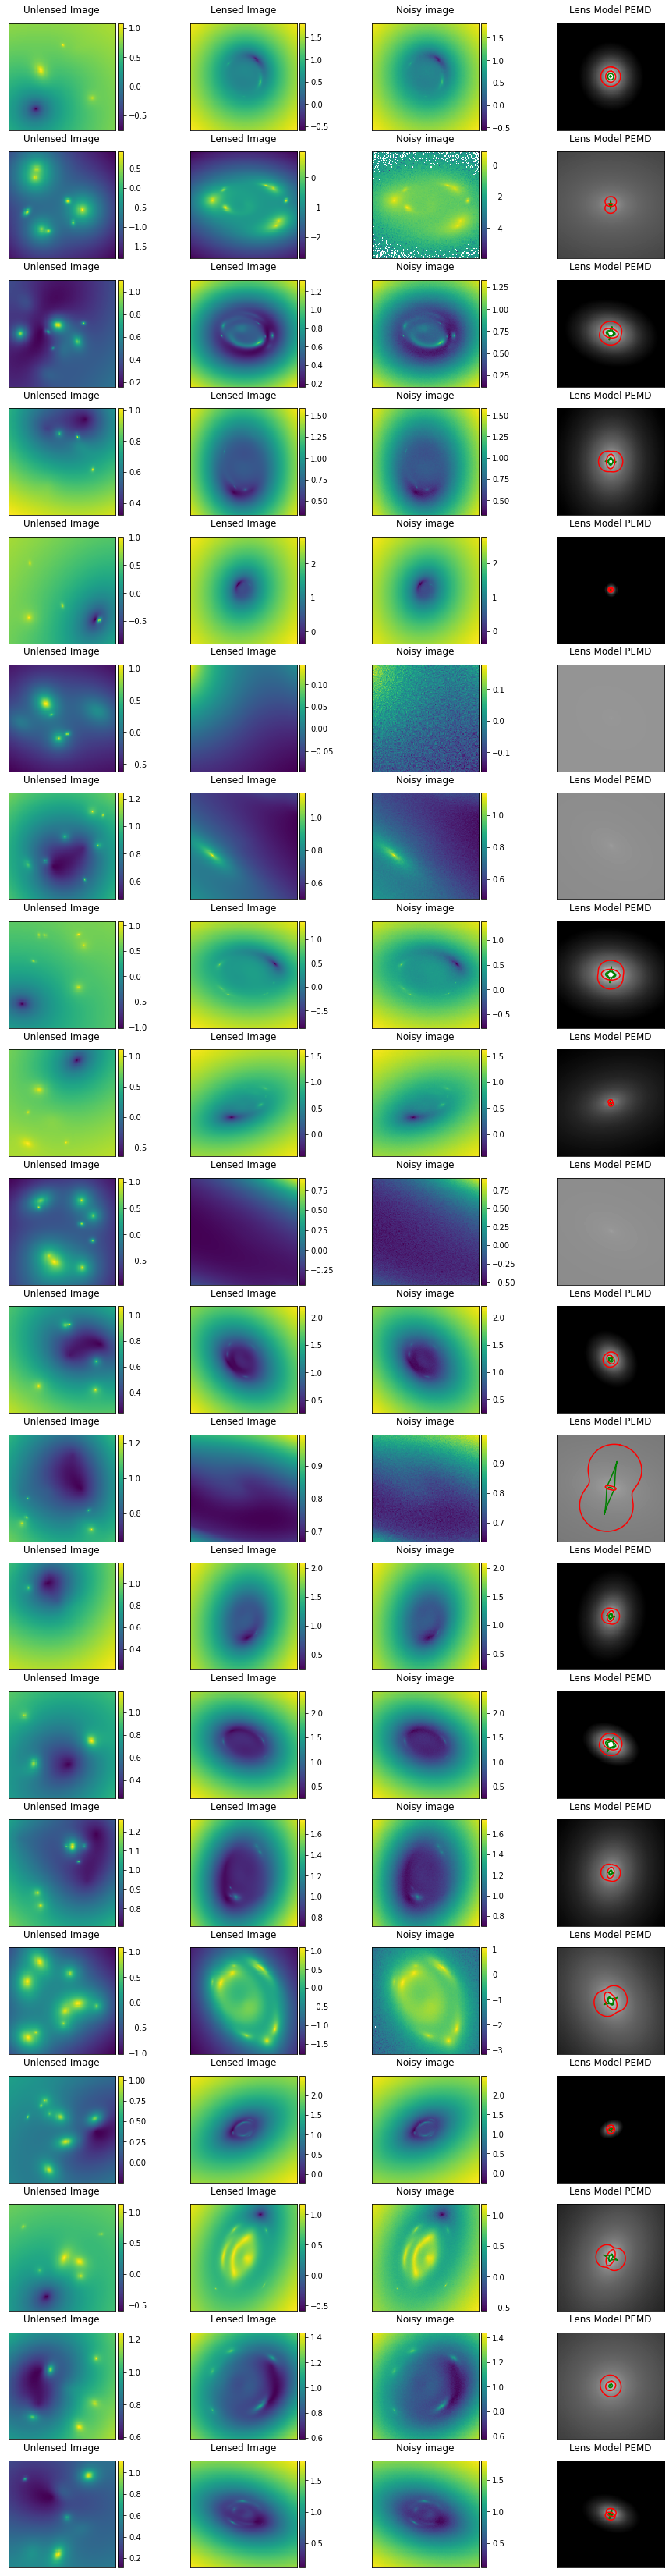

In [49]:

source_type_list=['SERSIC_ELLIPSE','POWER_LAW','ELLIPSOID','HERNQUIST','UNIFORM','GAUSSIAN_ELLIPSE','CHAMALEON','MULTI_GAUSSIAN_ELLIPSE']
nb_source=len(source_type_list)

numPix,deltaPix=128,0.05
##n is the number of data
n=30
## nb_affichage is the number of images plotted
nb_affichage=20

L_affichage=np.linspace(0,n-1,num=nb_affichage,dtype='int')
print(L_affichage)

vizualize_dataset(L_affichage,nb_source,unlensed_dataset,lensed_dataset,noisy_dataset,labelset,n,nb_affichage,numPix,deltaPix)

Plot Reconstruction Image

[ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


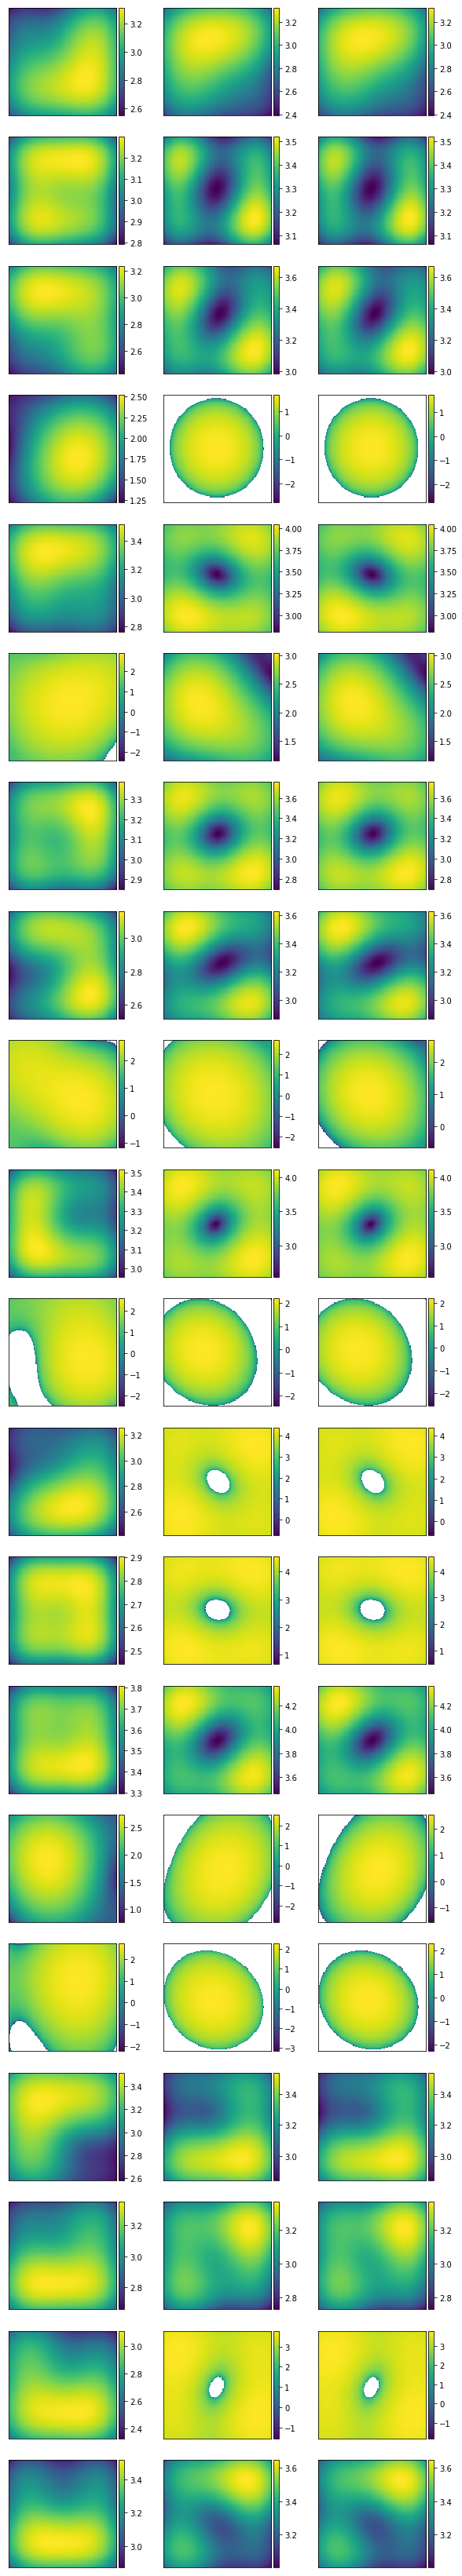

In [ ]:
source_type_list=['SERSIC_ELLIPSE','POWER_LAW','ELLIPSOID','HERNQUIST','UNIFORM','GAUSSIAN_ELLIPSE','CHAMALEON','MULTI_GAUSSIAN_ELLIPSE']

nb_affichage=len(L_affichage)
n=30
nb_source=len(source_type_list)

print(L_affichage)
vizualize_dataset_shapelet(L_affichage,dataset_reconstructed,n,nb_affichage,nb_source)

Plot distribution coeff shapelet 

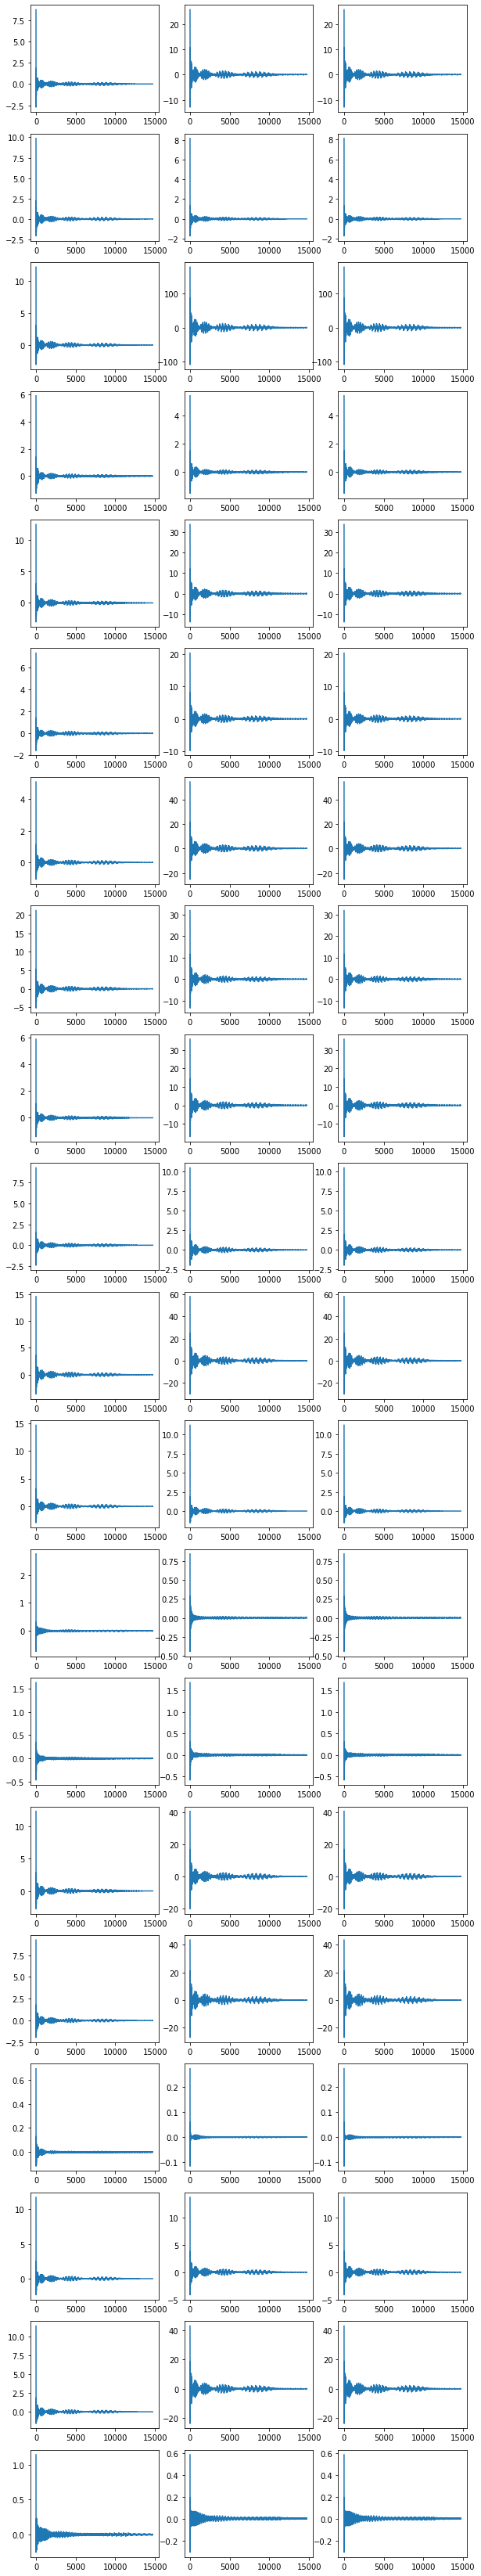

In [ ]:
nb_affichage=len(L_affichage)
n=30
nb_source=len(source_type_list)
len_coeff_shapelet=len(coeff_dataset[0][0])
vizualize_dataset_coeff_shapelet(len_coeff_shapelet,L_affichage,coeff_dataset,n,nb_affichage,nb_source)

# Network Model

In [ ]:
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image

        
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3),input_shape=(128, 128, 1),use_bias=False))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Conv2D(128, (3, 3) ,use_bias=False))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Conv2D(128, (3, 3),use_bias=False))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6,activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 64)      576       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 63, 63, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 63, 63, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 128)       73728     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 128)     

In [ ]:
x_train = lensed_dataset[0:7250].reshape(-1,128, 128, 1)
trainLabels=lensed_parameters_dataset[0:7250]
x_dev=lensed_dataset[7250:9000].reshape(-1,128, 128, 1)
devLabels=lensed_parameters_dataset[7250:9000]
x_test=lensed_dataset[9000:].reshape(-1,128, 128, 1)
testLabels=lensed_parameters_dataset[9000:]

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])

history = model.fit(x_train, trainLabels,batch_size=128, epochs=7, validation_data=(x_dev, devLabels))

Epoch 1/7
57/57 [==============================] - 7s 108ms/step - loss: 6.1429 - mse: 6.1429 - mae: 0.5497 - mape: 156445024.0000 - val_loss: 0.0939 - val_mse: 0.0939 - val_mae: 0.2035 - val_mape: 17293902.0000
Epoch 2/7
57/57 [==============================] - 6s 101ms/step - loss: 0.0848 - mse: 0.0848 - mae: 0.1985 - mape: 21448080.0000 - val_loss: 0.0849 - val_mse: 0.0849 - val_mae: 0.2032 - val_mape: 23491772.0000
Epoch 3/7
57/57 [==============================] - 6s 102ms/step - loss: 0.0779 - mse: 0.0779 - mae: 0.1908 - mape: 24930200.0000 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.2069 - val_mape: 26568318.0000
Epoch 4/7
57/57 [==============================] - 6s 101ms/step - loss: 0.0720 - mse: 0.0720 - mae: 0.1863 - mape: 30896836.0000 - val_loss: 0.0890 - val_mse: 0.0890 - val_mae: 0.2077 - val_mape: 24841756.0000
Epoch 5/7
57/57 [==============================] - 6s 102ms/step - loss: 0.0691 - mse: 0.0691 - mae: 0.1813 - mape: 29021868.0000 - val_loss: 0.0758 - val_

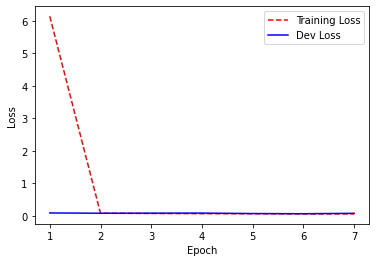

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
dev_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, dev_loss, 'b-')
plt.legend(['Training Loss', 'Dev Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

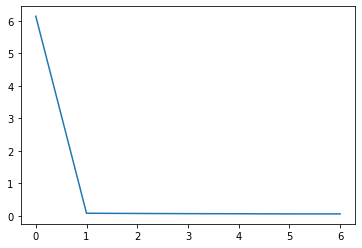

In [ ]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history.history['mse'])

pyplot.show()

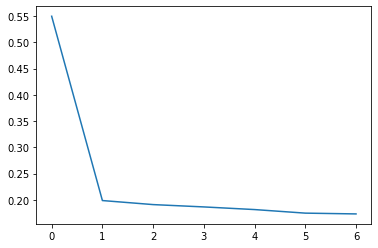

In [ ]:
pyplot.plot(history.history['mae'])
pyplot.show()

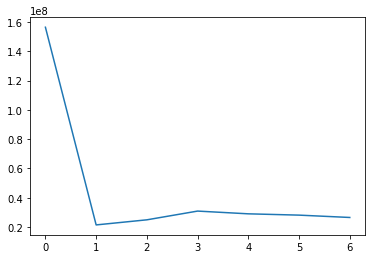

In [ ]:
pyplot.plot(history.history['mape'])
pyplot.show()

In [ ]:
test_results = model.predict(x_test)

In [ ]:
test_results_eval = model.evaluate(x_test, testLabels, verbose=0)

In [ ]:
import pandas as pd
testout = pd.DataFrame(model.predict(x_test))

In [ ]:
testout.columns = ['theta_E_out', 'gamma_out', 'center_x_out', 'center_y_out','e1_out', 'e2_out']
display(testout)

theta_E_out  gamma_out  center_x_out  center_y_out    e1_out    e2_out
0       0.471939   0.260333     -0.105819     -0.104372  0.164932 -0.293980
1       0.544474   0.339005     -0.117153     -0.133860  0.206598 -0.367187
2       0.533114   0.326685     -0.115378     -0.129242  0.200073 -0.355722
3       0.556665   0.352228     -0.119058     -0.138817  0.213601 -0.379491
4       0.584443   0.382357     -0.123399     -0.150110  0.229558 -0.407528
..           ...        ...           ...           ...       ...       ...
995     0.152415  -0.086226     -0.055889      0.025527 -0.018611  0.028506
996     0.559518   0.355323     -0.119504     -0.139976  0.215240 -0.382371
997     0.568114   0.364647     -0.120847     -0.143471  0.220178 -0.391047
998     0.596810   0.395770     -0.125331     -0.155137  0.236661 -0.420009
999     0.527606   0.320711     -0.114517     -0.127003  0.196909 -0.350163

[1000 rows x 6 columns]

In [ ]:
true_testout = pd.DataFrame(testLabels)
true_testout.columns = ['theta_E', 'gamma', 'center_x', 'center_y','e1', 'e2']
display(true_testout)

theta_E     gamma  center_x  center_y        e1        e2
0    0.679339 -0.171420       0.0       0.0 -0.046921  0.110119
1    0.102471  0.709973       0.0       0.0 -0.179894  0.181617
2    0.334430  0.522646       0.0       0.0  0.178270  0.018227
3    0.485778  0.394371       0.0       0.0  0.154252  0.027291
4    0.638975  0.798280       0.0       0.0  0.005837 -0.104000
..        ...       ...       ...       ...       ...       ...
995  0.671248 -0.799435       0.0       0.0  0.164222  0.072349
996  0.370898  0.246898       0.0       0.0  0.062359 -0.111973
997  0.319769  0.684753       0.0       0.0 -0.121073  0.040768
998  0.557005  0.895526       0.0       0.0  0.124545 -0.034677
999  0.825386  0.121170       0.0       0.0 -0.191982 -0.100009

[1000 rows x 6 columns]

# Network Model To find Unlensed Image

In [ ]:
x_train = lensed_dataset[0:7250].reshape(-1,128, 128, 1)
x_trainunlensed=unlensed_dataset[0:7250].reshape(-1,128, 128, 1)
x_dev=lensed_dataset[7250:9000].reshape(-1,128, 128, 1)
x_devunlensed=unlensed_dataset[7250:9000].reshape(-1,128, 128, 1)
x_test=lensed_dataset[9000:].reshape(-1,128, 128, 1)
x_testunlensed=unlensed_dataset[9000:].reshape(-1,128, 128, 1)

## Loss

In [ ]:
from skimage import measure
def compare_images(target, ref):
    target = np.squeeze(target/255)
    ref = np.squeeze(ref/255)
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores
# Loss functtion
def ssim_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
def psnr_loss(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, 1.0)
def mse_ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)) - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

## Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tqdm import tqdm
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import sys
import random
import warnings
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,BatchNormalization,Activation
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [ ]:
inputs = Input((128, 128, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3),  padding='same',use_bias=False) (s)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
c1 = Conv2D(16, (3, 3), padding='same',use_bias=False) (c1)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3),  padding='same',use_bias=False) (p1)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
c2 = Conv2D(32, (3, 3), padding='same',use_bias=False) (c2)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (p2)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (c3)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (c3)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), padding='same', use_bias=False) (p3)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
c4 = Conv2D(128, (3, 3), padding='same',use_bias=False) (c4)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), padding='same',use_bias=False) (p4)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)
c5 = Conv2D(256, (3, 3),  padding='same',use_bias=False) (c5)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3),  padding='same',use_bias=False) (u6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)
c6 = Conv2D(128, (3, 3),  padding='same',use_bias=False) (c6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (u7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (c7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (c7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), padding='same',use_bias=False) (u8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)
c8 = Conv2D(32, (3, 3), padding='same',use_bias=False) (c8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3),  padding='same',use_bias=False) (u9)
c9 = BatchNormalization()(c9)
c9 = Activation('relu')(c9)
c9 = Conv2D(16, (3, 3), padding='same',use_bias=False) (c9)
c9 = BatchNormalization()(c9)
c9 = Activation('relu')(c9)

out = Conv2D(1, (1, 1), use_bias=False) (c9)
out = BatchNormalization()(out)
outputs = Activation('linear')(out)
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model6 = Model(inputs=[inputs], outputs=[outputs])
model6.compile(loss=mse_ssim_loss, optimizer=optimizer, metrics=['mse',ssim_loss,psnr_loss])


In [ ]:
model6.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 128, 128, 16  144         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

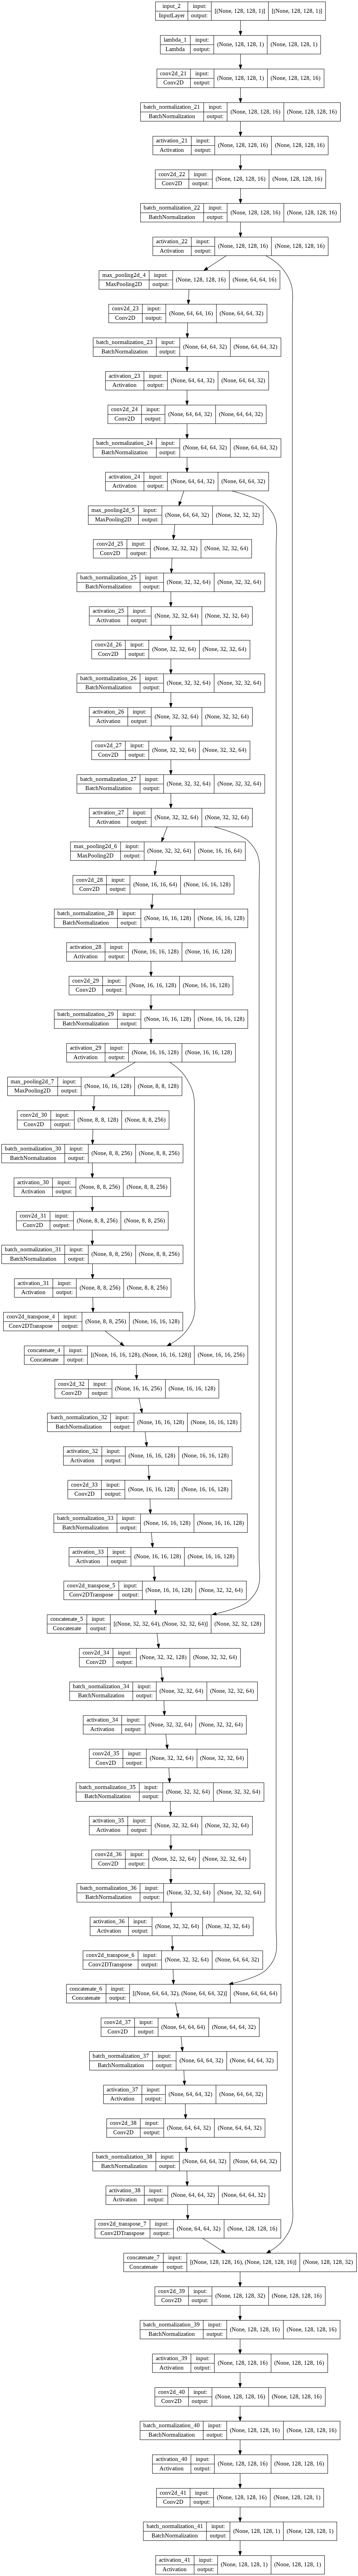

In [ ]:
tf.keras.utils.plot_model(model6, show_shapes=True)

## ds

In [ ]:
history6 = model6.fit(x_train, x_trainunlensed,batch_size=128, epochs=  10, validation_data=(x_dev, x_devunlensed))

Epoch 1/10
57/57 [==============================] - 20s 343ms/step - loss: 0.0939 - mse: 0.8192 - ssim_loss: 0.2747 - psnr_loss: 2.2006 - val_loss: 1.9107 - val_mse: 2.5264 - val_ssim_loss: 0.3853 - val_psnr_loss: -2.7659
Epoch 2/10
57/57 [==============================] - 19s 340ms/step - loss: 0.0277 - mse: 0.7531 - ssim_loss: 0.2747 - psnr_loss: 2.5245 - val_loss: 1.5317 - val_mse: 2.1312 - val_ssim_loss: 0.4015 - val_psnr_loss: -2.2492
Epoch 3/10
57/57 [==============================] - 20s 343ms/step - loss: 0.0248 - mse: 0.7536 - ssim_loss: 0.2710 - psnr_loss: 2.6382 - val_loss: 2.4711 - val_mse: 3.0639 - val_ssim_loss: 0.4084 - val_psnr_loss: -3.7558
Epoch 4/10
57/57 [==============================] - 20s 345ms/step - loss: -0.0119 - mse: 0.7170 - ssim_loss: 0.2710 - psnr_loss: 2.7786 - val_loss: 2.4079 - val_mse: 3.0066 - val_ssim_loss: 0.4025 - val_psnr_loss: -3.5609
Epoch 5/10
57/57 [==============================] - 20s 346ms/step - loss: -0.0062 - mse: 0.7219 - ssim_loss: 0

In [ ]:
test_results = model6.predict(x_test)

In [ ]:
def exporter():
    """Export utility modified from https://stackoverflow.com/a/41895194
    Returns export decorator, __all__ list
    """
    all_ = []

    def decorator(obj):
        all_.append(obj.__name__)
        return obj

    return decorator, all_


export, __all__ = exporter()
__all__.append("exporter")


@export
def image_grid(
    shape,
    pixel_width,
    x0=0,
    y0=0,
    edges=True,
):
    nx, ny = shape
    dx = nx * pixel_width
    dy = nx * pixel_width
    extra = 1 if edges else 0
    x = np.linspace(-dx / 2, dx / 2, nx + extra) + x0
    y = np.linspace(-dy / 2, dy / 2, ny + extra) + y0
    return x, y


@export
def plot_image(
    img,
    pixel_width,
    log_scale=True,
    label="HST F814W",
    colorbar=True,
    adjust_ax=True,
    vmin=None,
    vmax=None,
    **kwargs
):

    # Set reasonable defaults
    if vmax is None:
        vmax = img.max()
    if vmin is None:
        if log_scale:
            vmin = vmax * 1e-3
        else:
            vmin = img.min()
    kwargs.setdefault(
        "norm",
        matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
        if log_scale
        else matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),
    )
    kwargs.setdefault("cmap", "magma")

    # Plot image, note transposition
    plt.pcolormesh(
        *image_grid(img.shape, pixel_width), img.clip(vmin, None).T, **kwargs
    )
    if adjust_ax:
        plt.gca().set_aspect("equal")

    if colorbar:
        # Plot colorbar
        cbar = plt.colorbar(label=label, extend="both")
        cax = cbar.ax
        # Format colobar ticks as scalars (not 10^x)
        cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%g"))
        if len(cbar.get_ticks()) < 2:
            # If there are very few colorbar ticks, show minor ticks too
            cax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%g"))
            cax.tick_params(axis="y", labelsize=7, which="minor")

    plt.xlabel("[Arcseconds]")
    plt.ylabel("[Arcseconds]")


@export
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    plt.gca().add_patch(
        matplotlib.patches.Rectangle(
            (x[0], y[0]), x[1] - x[0], y[1] - y[0], facecolor="none", **kwargs
        )
    )#

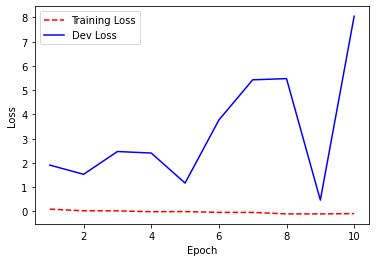

In [ ]:
# Get training and test loss histories
training_loss = history6.history['loss']
dev_loss = history6.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, dev_loss, 'b-')
plt.legend(['Training Loss', 'Dev Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

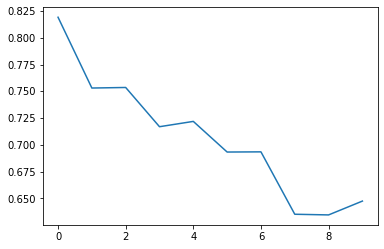

In [ ]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history6.history['mse'])

pyplot.show()

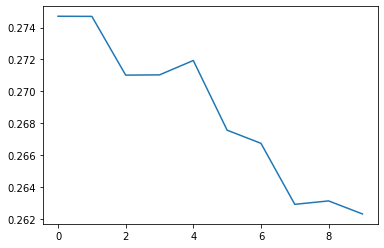

In [ ]:
pyplot.plot(history6.history["ssim_loss"])
pyplot.show()

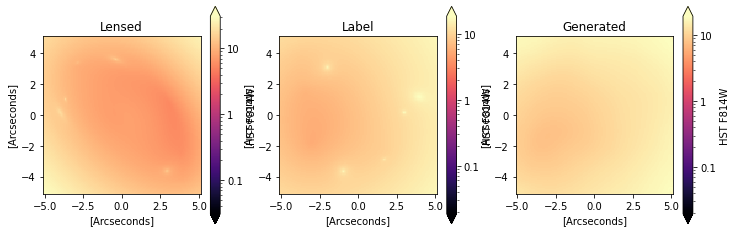

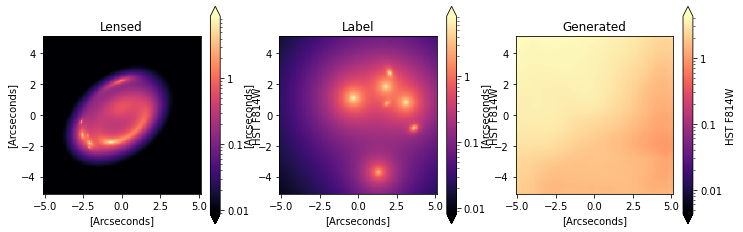

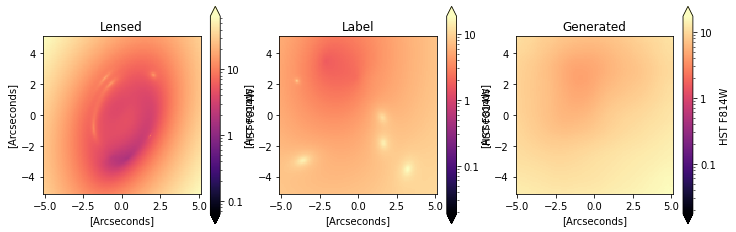

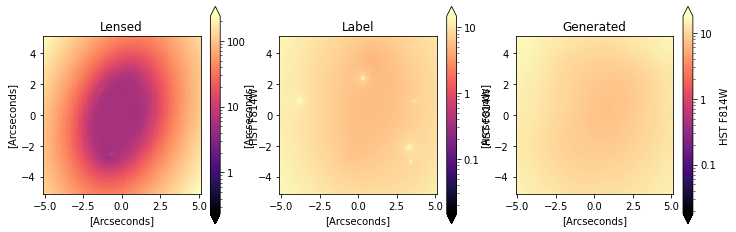

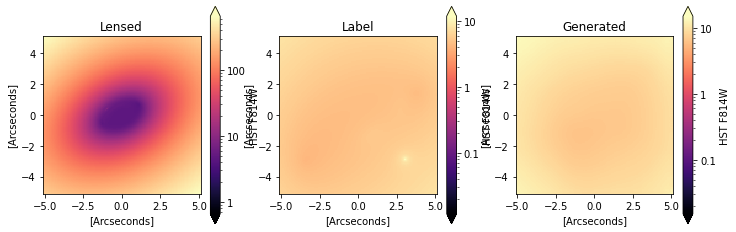

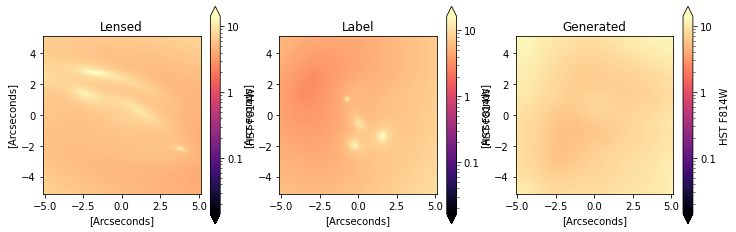

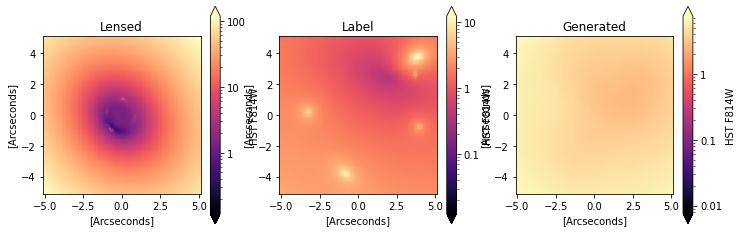

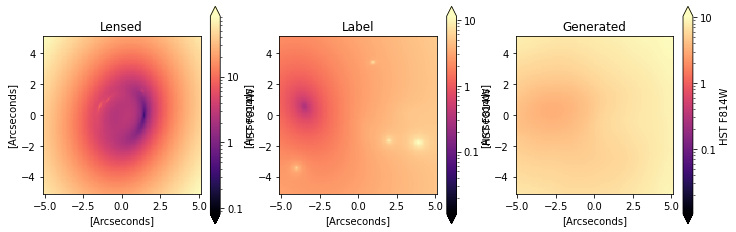

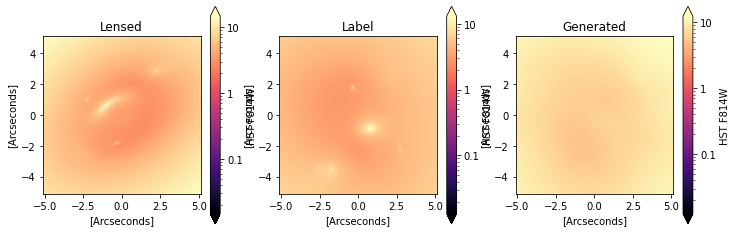

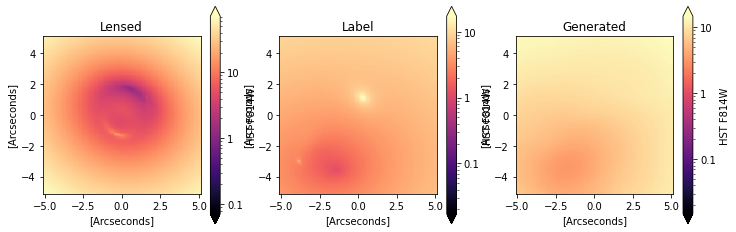

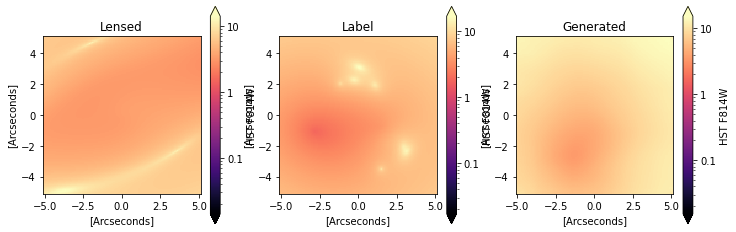

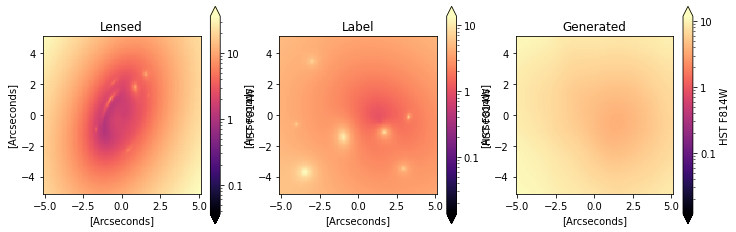

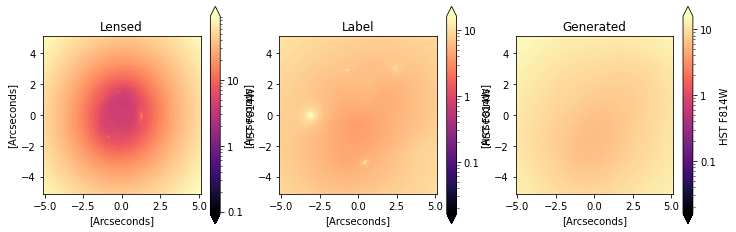

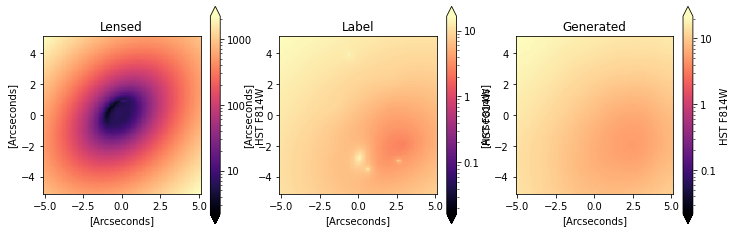

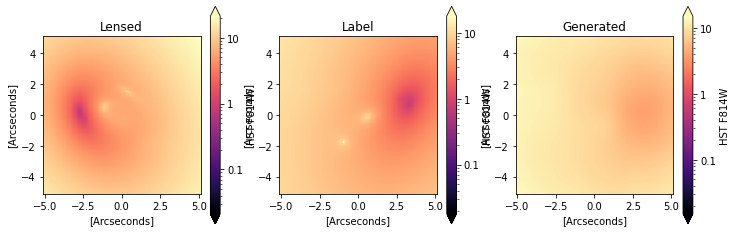

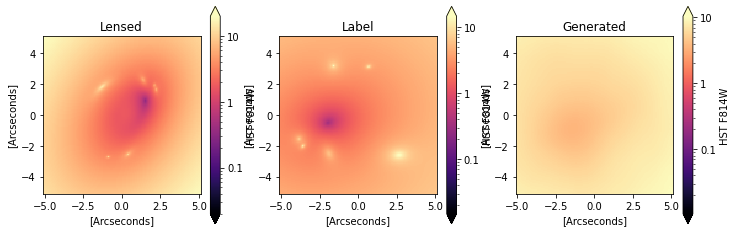

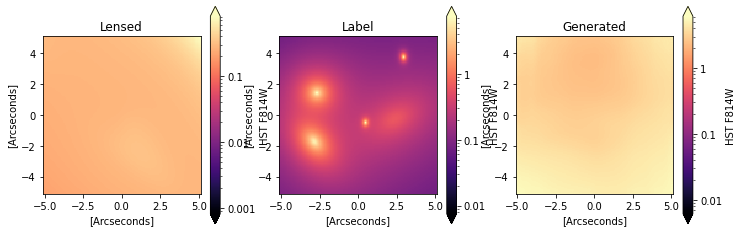

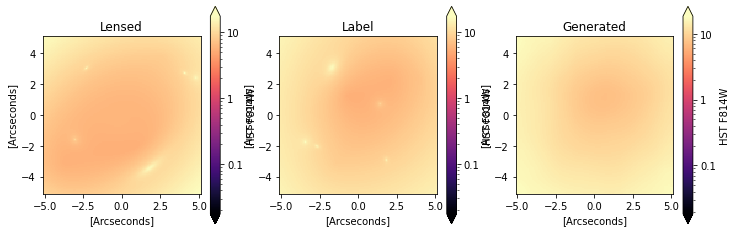

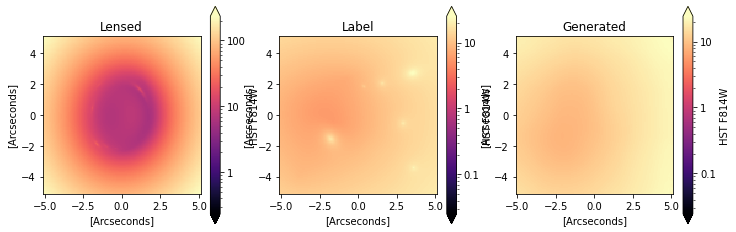

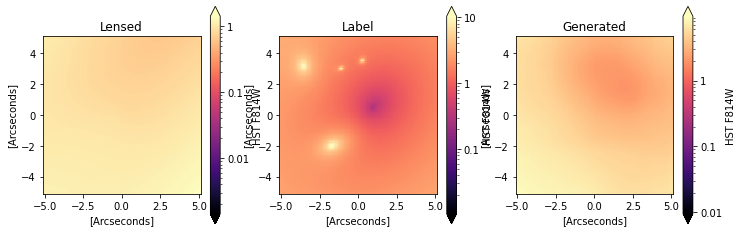

In [ ]:
for i in range(20):
   plot = True
   if plot:
     f, axes = plt.subplots(ncols=3, figsize=(12, 4))
     lensed= np.squeeze(x_test[i])
     label = np.squeeze(x_testunlensed[i])  
     pred = np.squeeze(test_results[i])
     plt.sca(axes[0])
     plot_image(lensed,pixel_width=0.08)
     plt.title("Lensed")
        
     plt.sca(axes[1])
     plot_image(label,pixel_width=0.08)
     plt.title("Label")

     plt.sca(axes[-1])
     plot_image(pred,pixel_width=0.08)
     plt.title("Generated")